In [53]:
import pandas as pd
import awswrangler as wr
import boto3
#import statmodels.tsa as tsa
from sklearn.preprocessing import MinMaxScaler

In [54]:
boto3.setup_default_session(profile_name='patricio_ferreira_fellow_dssgx_24')

In [55]:
bucket = "dssgx-munich-2024-bavarian-forest"
raw_data_folder = "raw-data"
preprocessed_data_folder = "preprocessed_data"

In [56]:
def load_csv_files_from_aws_s3(path: str, **kwargs) -> pd.DataFrame:
    """Loads individual or multiple CSV files from an AWS S3 bucket.

    Args:
        path (str): The path to the CSV files on AWS S3.
        **kwargs: Additional arguments to pass to the read_csv function.

    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV files.
    """

    df = wr.s3.read_csv(path=path, **kwargs)
    return df

joined_data = load_csv_files_from_aws_s3(
    path="s3://dssgx-munich-2024-bavarian-forest/preprocessed_data/joined_sensor_weather_visitorcenter_2016-2024.csv"
)

joined_data.head()

c:\Users\patricio\.pyenv-win-venv\envs\bf_dssdgx\lib\site-packages\awswrangler\s3\_read_text_core.py:115: DtypeWarning: Columns (72,73,74,75,83,84,85,86,87,88,89,90,91,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df: pd.DataFrame = parser_func(f, **pandas_kwargs)


,Time,Bayerisch Eisenstein IN,Bayerisch Eisenstein OUT,Brechhäuslau IN,Brechhäuslau OUT,Deffernik IN,Deffernik OUT,Diensthüttenstraße IN,Diensthüttenstraße OUT,Felswandergebiet IN,...,Racheldiensthuette_geoeffnet,Waldschmidthaus_geoeffnet,Falkensteinschutzhaus_geoeffnet,Schwellhaeusl_geoeffnet,Temperatur,Niederschlagsmenge,Schneehoehe,GS mit,GS max,Total
0,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# First Draft

- 2023-March 2024
- Target =  Traffic Abs
- Test = 2024
- Features: Weather

In [57]:
start_date = "2023-01-01"
end_date = "2024-03-31"

mask = (joined_data['Time'] > start_date) & (joined_data['Time'] <= end_date)

df = joined_data.loc[mask]
df = df.set_index('Time')

In [58]:
df[['Tag',
 'Monat',
 'Jahr',
 'Wochentag',
 'Wochenende',
 'Jahreszeit',
 'Laubfärbung']].isna().sum()

Tag            0
Monat          0
Jahr           0
Wochentag      0
Wochenende     0
Jahreszeit     0
Laubfärbung    0
dtype: int64

In [59]:
[col for col in df.columns if "IN" not in col and "OUT" not in col]

['working_sensors',
 'traffic_norm',
 'traffic_abs',
 'diff_norm',
 'diff_abs',
 'occupancy_norm',
 'occupancy_abs',
 'Temperature (°C)',
 'Relative Humidity (%)',
 'Precipitation (mm)',
 'Wind Speed (km/h)',
 'Sunshine Duration (min)',
 'Tag',
 'Monat',
 'Jahr',
 'Wochentag',
 'Wochenende',
 'Jahreszeit',
 'Laubfärbung',
 'Besuchszahlen_HEH',
 'Besuchszahlen_HZW',
 'Besuchszahlen_WGM',
 'Parkpl_HEH_PKW',
 'Parkpl_HEH_BUS',
 'Parkpl_HZW_PKW',
 'Parkpl_HZW_BUS',
 'Schulferien_Bayern',
 'Schulferien_CZ',
 'Feiertag_Bayern',
 'Feiertag_CZ',
 'HEH_geoeffnet',
 'HZW_geoeffnet',
 'WGM_geoeffnet',
 'Lusenschutzhaus_geoeffnet',
 'Racheldiensthuette_geoeffnet',
 'Waldschmidthaus_geoeffnet',
 'Falkensteinschutzhaus_geoeffnet',
 'Schwellhaeusl_geoeffnet',
 'Temperatur',
 'Niederschlagsmenge',
 'Schneehoehe',
 'GS mit',
 'GS max',
 'Total']

In [60]:
# select columns for modeling

selected_cols = ['traffic_abs',
                'Temperature (°C)',
                'Relative Humidity (%)',
                'Precipitation (mm)',
                'Wind Speed (km/h)',
                'Sunshine Duration (min)',
                'Wochentag',
                'Wochenende',
                'Jahreszeit',
                'Laubfärbung']

df_first_draft = df[selected_cols]

In [61]:
df_first_draft = pd.get_dummies(df_first_draft, columns=['Wochentag', 'Jahreszeit'], drop_first=True)


In [62]:
get_int_cols = ['Wochenende', 'Laubfärbung', 'Wochentag_Donnerstag',
       'Wochentag_Freitag', 'Wochentag_Mittwoch', 'Wochentag_Montag',
       'Wochentag_Samstag', 'Wochentag_Sonntag', 'Jahreszeit_Herbst',
       'Jahreszeit_Sommer', 'Jahreszeit_Winter']

for col in get_int_cols:
    df_first_draft[col] = df_first_draft[col].astype(int)

df_first_draft

,traffic_abs,Temperature (°C),Relative Humidity (%),Precipitation (mm),Wind Speed (km/h),Sunshine Duration (min),Wochenende,Laubfärbung,Wochentag_Donnerstag,Wochentag_Freitag,Wochentag_Mittwoch,Wochentag_Montag,Wochentag_Samstag,Wochentag_Sonntag,Jahreszeit_Herbst,Jahreszeit_Sommer,Jahreszeit_Winter
Time,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,65.0,6.4,82.0,0.0,9.0,0.0,1,0,0,0,0,0,0,1,0,0,1
2023-01-01 01:00:00,104.0,6.0,84.0,0.0,8.3,0.0,1,0,0,0,0,0,0,1,0,0,1
2023-01-01 02:00:00,5.0,6.1,83.0,0.0,7.6,0.0,1,0,0,0,0,0,0,1,0,0,1
2023-01-01 03:00:00,0.0,6.6,83.0,0.0,7.9,0.0,1,0,0,0,0,0,0,1,0,0,1
2023-01-01 04:00:00,1.0,6.4,83.0,0.0,7.6,0.0,1,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-30 19:00:00,21.0,13.9,48.0,0.0,17.6,0.0,1,0,0,0,0,0,1,0,0,0,0
2024-03-30 20:00:00,3.0,13.1,48.0,0.0,17.6,0.0,1,0,0,0,0,0,1,0,0,0,0
2024-03-30 21:00:00,1.0,11.5,55.0,0.0,14.8,0.0,1,0,0,0,0,0,1,0,0,0,0


In [63]:
# Store the original index
original_index = df_first_draft.index

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(df_first_draft)

# Create DataFrame with original index and column names
df_min_max = pd.DataFrame(scaled_data, index=original_index, columns=df_first_draft.columns)

In [64]:
df_min_max.head()

,traffic_abs,Temperature (°C),Relative Humidity (%),Precipitation (mm),Wind Speed (km/h),Sunshine Duration (min),Wochenende,Laubfärbung,Wochentag_Donnerstag,Wochentag_Freitag,Wochentag_Mittwoch,Wochentag_Montag,Wochentag_Samstag,Wochentag_Sonntag,Jahreszeit_Herbst,Jahreszeit_Sommer,Jahreszeit_Winter
Time,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0.028979,0.454352,0.780488,0.0,0.208995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2023-01-01 01:00:00,0.046366,0.445860,0.804878,0.0,0.190476,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2023-01-01 02:00:00,0.002229,0.447983,0.792683,0.0,0.171958,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2023-01-01 03:00:00,0.000000,0.458599,0.792683,0.0,0.179894,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2023-01-01 04:00:00,0.000446,0.454352,0.792683,0.0,0.171958,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [102]:
ts_df = df_min_max["traffic_abs"]

In [103]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_df)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -9.104467969940492
p-value: 3.533101616395444e-15


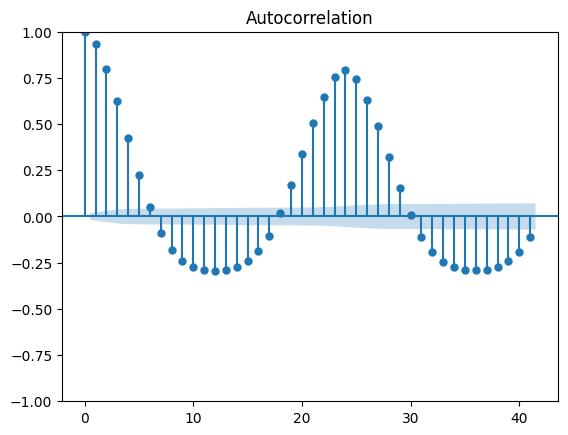

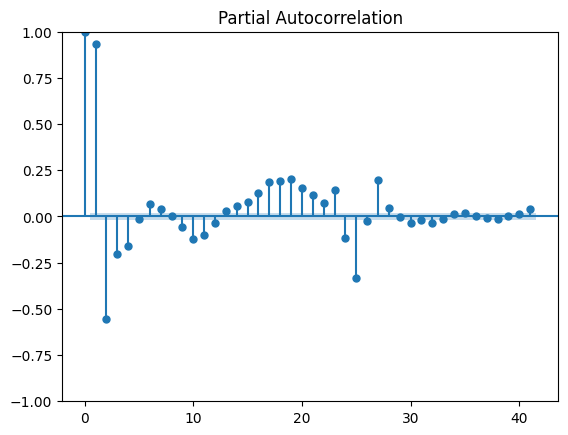

In [104]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_df)
plot_pacf(ts_df)
plt.show()

In [105]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(model_auto.resid(), lags=10)
print(lb_test)

       lb_stat     lb_pvalue
1    76.742383  1.947781e-18
2    76.950235  1.951950e-17
3    95.527155  1.422402e-20
4   108.841471  1.285426e-22
5   116.777830  1.510025e-23
6   126.397849  7.365237e-25
7   137.004729  2.154731e-26
8   193.256460  1.681146e-37
9   230.142527  1.535393e-44
10  230.942711  5.448627e-44


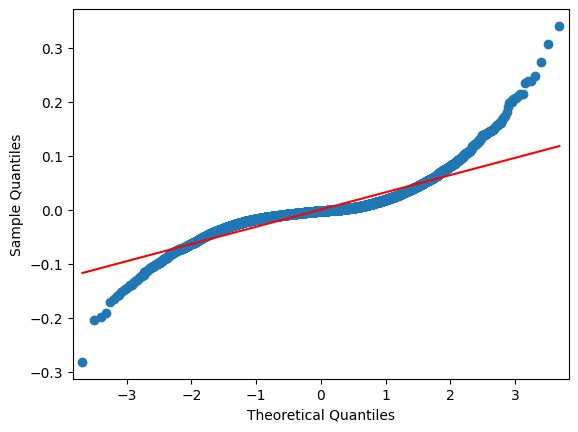

In [106]:
from statsmodels.graphics.gofplots import qqplot

qqplot(model_auto.resid(), line='s')
plt.show()

In [82]:
train_univ = df_min_max["traffic_abs"][df_min_max.index <= "2023-12-31 23:00:00"]
test_univ = df_min_max["traffic_abs"][df_min_max.index > "2023-12-31 23:00:00"]

train_multiv = df_min_max[df_min_max.index <= "2023-12-31 23:00:00"]
test_multiv = df_min_max[df_min_max.index > "2023-12-31 23:00:00"]

In [89]:
train_univ

Time
2023-01-01 00:00:00    0.028979
2023-01-01 01:00:00    0.046366
2023-01-01 02:00:00    0.002229
2023-01-01 03:00:00    0.000000
2023-01-01 04:00:00    0.000446
                         ...   
2023-12-31 19:00:00    0.010700
2023-12-31 20:00:00    0.012037
2023-12-31 21:00:00    0.024075
2023-12-31 22:00:00    0.033883
2023-12-31 23:00:00    0.007133
Name: traffic_abs, Length: 8760, dtype: float64

## ARIMA: Univariate

Best ARIMA order: (5, 1, 4)


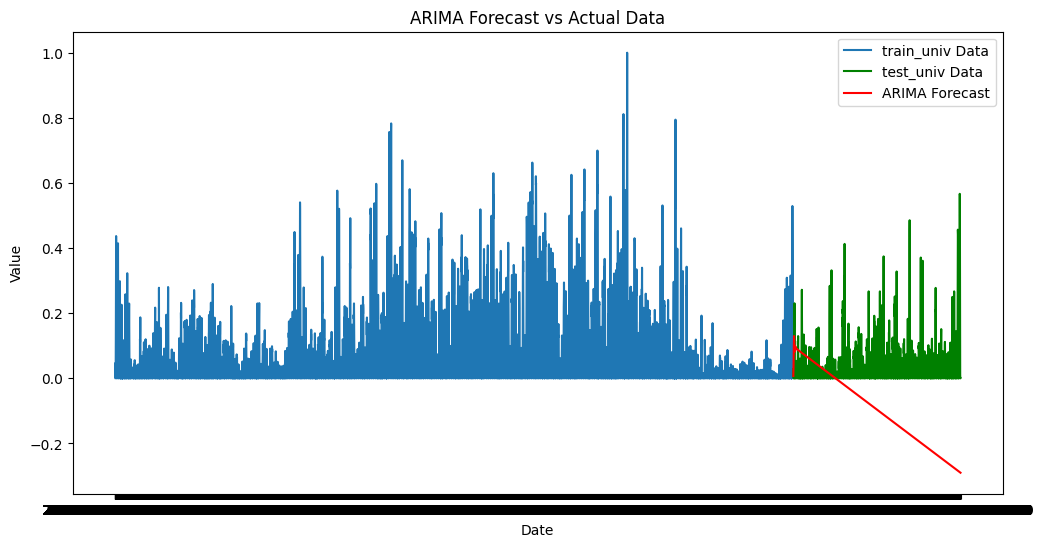

In [100]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt


# Find the best ARIMA model using auto_arima
model_auto = auto_arima(train_univ,
                        error_action='ignore', 
                        suppress_warnings=True,
                        stepwise=True)

# Print the best ARIMA parameters
print(f'Best ARIMA order: {model_auto.order}')

# Fit the ARIMA model with the best parameters
model_auto_fit = model_auto.fit(train_univ)

# Forecast
forecast_steps = len(test_univ)
forecast = model_auto_fit.predict(n_periods=forecast_steps)

# Convert forecast to DataFrame
forecast_index = test_univ.index
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train_univ, label='train_univ Data')
plt.plot(test_univ, label='test_univ Data', color='green')
plt.plot(forecast_df, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


## VARIMA: Multivariate

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
# Fit the VAR model
model_var = VAR(train_univ)
model_var_fit = model_var.fit(maxlags=15)  # Choose lag length as appropriate

# Forecast
forecast_var = model_var_fit.forecast(train_univ.values[-model_var_fit.k_ar:], steps=len(test_univ))

# Convert forecast to DataFrame
forecast_var_df = pd.DataFrame(forecast_var, index=test_univ.index, columns=train_univ.columns)

# Plot actual vs. forecast for each series
plt.figure(figsize=(12, 12))
for col in train_univ.columns:
    plt.subplot(len(train_univ.columns), 1, list(train_univ.columns).index(col) + 1)
    plt.plot(train_univ[col], label='Train Data')
    plt.plot(test_univ[col], label='Test Data', color='green')
    plt.plot(forecast_var_df[col], label='VAR Forecast', color='red')
    plt.legend()
    plt.title(f'VAR Forecast vs Actual Data for {col}')
    plt.xlabel('Date')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

## EXPONENTIAL SMOOTHING

In [94]:
test_univ.values

array([0.02853321, 0.00356665, 0.        , ..., 0.00044583, 0.        ,
       0.00044583])

In [99]:
import pandas as pd
import plotly.express as px
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# Assume train_univ and test_univ are already defined as DataFrames with timestamp as index
# and "traffic_abs" as the target value column.

# Fit Exponential Smoothing model
model = ETSModel(train_univ.values, seasonal='add', seasonal_periods=24)  # 24 hours for daily seasonality
model_fit = model.fit()

# Forecast
forecast_steps = len(test_univ)
forecast = model_fit.forecast(steps=forecast_steps)

# Convert forecast to DataFrame
forecast_index = test_univ.index
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

# Plot results using Plotly Express
fig = px.line(train_univ, x=train_univ.index, y=train_univ.values, title='Exponential Smoothing Forecast vs Actual Data', labels={'x': 'Date', 'y': 'Traffic Abs'})
fig.add_scatter(x=test_univ.index, y=test_univ.values, mode='lines', name='Test Data', line=dict(color='green'))
fig.add_scatter(x=forecast_df.index, y=forecast_df['Forecast'], mode='lines', name='Exponential Smoothing Forecast', line=dict(color='red'))

fig.update_layout(xaxis_title='Date', yaxis_title='Traffic Abs')
fig.show()
